# Argo one filter scale

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

### Things to work on:
- For new filtering functions:
    - need to make new mask variable that will enable boundary correction feature
    - need to correct mult_log --> I think it's because I create lsig
- Use these functions to perform the above calculations about "MKE" and "EKE" on one scale:
    - Pass temperature signal through filter at l=100m, then square the results <-- MKE
    - Square the temperature signal, pass it through filter at l=100m, then subtract MKE <-- EKE

### Load and plot data

In [2]:
import my_stats

In [3]:
#glider data
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
gselect=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))
gselect_filt=my_stats.glider_ds_filt(gselect,1,4,50)
gselect_var=my_stats.glider_var(gselect,gselect_filt)

#argo box
box=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
aselect=my_stats.get_ds_interp(box,0,2000,4)
aselect_filt=my_stats.get_ds_filt(aselect,1,4,50)
aselect_var=my_stats.get_var(aselect,aselect_filt)

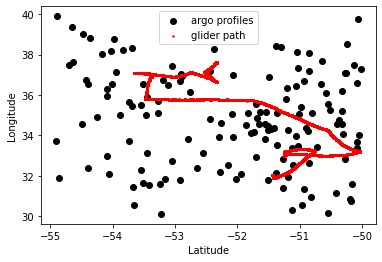

In [4]:
plt.scatter(aselect.LATITUDE,aselect.LONGITUDE,color='black',label='argo profiles')
plt.scatter(gselect.latitude,gselect.longitude,color='r',s=2,label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

Text(0.5, 1.0, 'Argo Box')

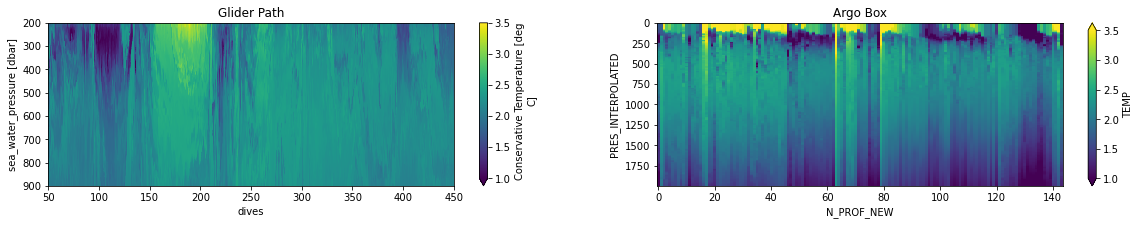

In [5]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
gselect.CT.plot(x='dives',y='ctd_pressure',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Glider Path')

plt.subplot(1,2,2)
aselect.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

## Dhruv's filtering methods/functions

In [6]:
import funcs

In [7]:
#I'm not sure that I defined dx and N correctly for this dataset

dx = (aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=1)-aselect.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
N = len(aselect.PRES_INTERPOLATED) +1
lfilter = 50*dx
sigmafilter = lfilter/np.sqrt(12)

nfilter_hat = lfilter/dx 
nfilter_gauss = sigmafilter/dx

f_hat = funcs.top_hat_kernel(nfilter_hat, N/2-1)
f_gauss = funcs.gaussian_kernel(nfilter_gauss, N/2-1)

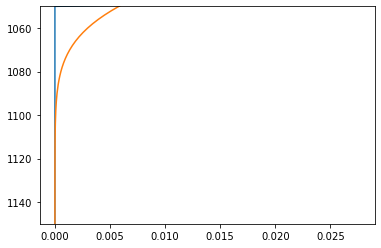

In [8]:
x=aselect.PRES_INTERPOLATED

plt.plot(f_hat, x)
plt.plot(f_gauss, x)
plt.ylim(1050,1150)
plt.gca().invert_yaxis()
#plt.ylabel('PRES_INTERPOLATED [m]')

In [9]:
f = aselect.TEMP.isel(N_PROF=0)
f_num = int(f.N_PROF)

f_l_hat = funcs.my_filter1d(f.values, nfilter_hat, funcs.top_hat_kernel, mode='wrap')
f_l_gauss = funcs.my_filter1d(f.values, nfilter_gauss, funcs.gaussian_kernel, mode='wrap')

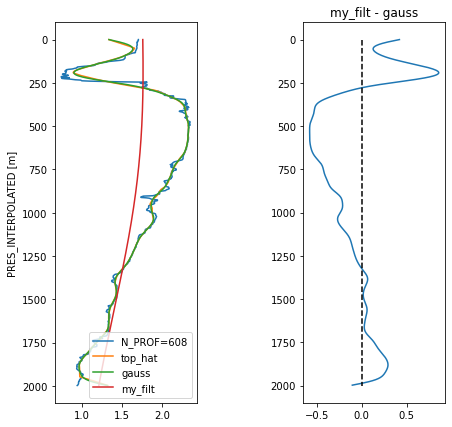

In [10]:
plt.figure(figsize=(7,7))

plt.subplot(1,2,1)
plt.plot(f, x, label='N_PROF={}'.format(f_num))
plt.plot(f_l_hat, x, label='top_hat')
plt.plot(f_l_gauss, x, label='gauss')
plt.plot(aselect_filt.sel(N_PROF=f_num).isel(FILT_SCALE=35), x, label='my_filt')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.legend()

plt.subplot(1,2,2)
plt.plot(aselect_filt.sel(N_PROF=f_num).isel(FILT_SCALE=35)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('my_filt - gauss')

plt.subplots_adjust(wspace=0.75)

There are obviously some differences between Dhruv's functions and mine. Need to combine the functionality of both:
- Dhruv's functions: use this method to determine dx, N, etc. Function should read in filter scale input of meters.
- My functions: use this method to repeatedly filter at multiple scales. Function should return a nicely formatted xr array.

## Correcting my get_ds_interp function

In [12]:
import scipy.ndimage as filter
from funcs import convolve1d

### Function to return all profiles filtered at one scale

Dhruv's suggestion for working with boundaries/nans:
- Create new variable "mask", where mask = 0 when we are in boundary that should be removed and mask = 1 when we are in usable data
- We can select where to plot data using `.where(mask=1)`
- This will keep dimensions the same for plotting and also not nan out any values

In [74]:
scale=100
ds_interp = aselect
start = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0).values + (scale-1)
end = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=-1).values - (scale-1)
pres = ds_interp.PRES_INTERPOLATED.where(ds_interp.PRES_INTERPOLATED>start).where(ds_interp.PRES_INTERPOLATED<end).values


array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,  100.,  102.,  104.,  106.,
        108.,  110.,  112.,  114.,  116.,  118.,  120.,  122.,  124.,
        126.,  128.,  130.,  132.,  134.,  136.,  138.,  140.,  142.,
        144.,  146.,  148.,  150.,  152.,  154.,  156.,  158.,  160.,
        162.,  164.,  166.,  168.,  170.,  172.,  174.,  176.,  178.,
        180.,  182.,  184.,  186.,  188.,  190.,  192.,  194.,  196.,
        198.,  200.,  202.,  204.,  206.,  208.,  210.,  212.,  214.,
        216.,  218.,  220.,  222.,  224.,  226.,  228.,  230.,  232.,
        234.,  236.,  238.,  240.,  242.,  244.,  246.,  248.,  250.,
        252.,  254.,

In [13]:
def one_filt_scale(ds_interp, scale, variable='TEMP', boundary_correction=False):

    if boundary_correction==True:
        start = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0).values + (scale-1)
        end = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=-1).values - (scale-1)
        pres= ds_interp.PRES_INTERPOLATED.where(ds_interp.PRES_INTERPOLATED>start).where(ds_interp.PRES_INTERPOLATED<end).values
        pres0 = pres[~(np.isnan(pres))]
        ds_interp = ds_interp.sel(PRES_INTERPOLATED=pres0)
        
    dx = (ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=1)-ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0)).values
    N = len(ds_interp.PRES_INTERPOLATED)+1
    lfilter = scale
    sigmafilter = lfilter/np.sqrt(12)
    nfilter = sigmafilter/dx
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0]))
    temp[:,:] = filter.gaussian_filter1d(ds_interp[variable], sigma=nfilter, mode='wrap')
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED'], coords={'N_PROF':ds_interp.N_PROF, 'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    
    return ds_filt

In [14]:
f_l = one_filt_scale(aselect,100)

In [15]:
f_l_bound = one_filt_scale(aselect,100, boundary_correction=True)

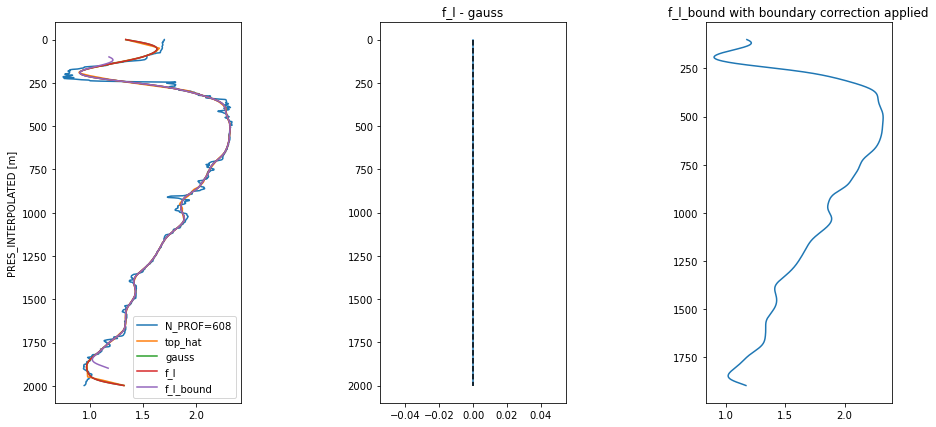

In [16]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
plt.plot(f, x, label='N_PROF={}'.format(f_num))
plt.plot(f_l_gauss, x, label='gauss')
plt.plot(f_l.sel(N_PROF=f_num), x, label='f_l')
plt.plot(f_l_bound.sel(N_PROF=f_num), f_l_bound.PRES_INTERPOLATED, label='f_l_bound')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.legend()

plt.subplot(1,3,2)
plt.plot(f_l.sel(N_PROF=f_num)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('f_l - gauss')

plt.subplot(1,3,3)
plt.plot(f_l_bound.sel(N_PROF=f_num), f_l_bound.PRES_INTERPOLATED)
plt.gca().invert_yaxis()
plt.title('f_l_bound with boundary correction applied')

plt.subplots_adjust(wspace=0.75)

Okay this function looks good! It matches the results from Dhruv's function for this profile, and the boundary correction seems to work well at removing the length of filter scale at each end of a profile. Now to make another function that returns multiple filter scales at once

### Function to return all profiles filtered at multiple scales

In [101]:
mult_log.FILT_SCALE

<xarray.DataArray 'FILT_SCALE' (FILT_SCALE: 100)>
array([ 50.      ,  51.270886,  52.574076,  53.910389,  55.280669,  56.685777,
        58.126601,  59.604047,  61.119046,  62.672554,  64.265547,  65.899031,
        67.574035,  69.291613,  71.052849,  72.85885 ,  74.710757,  76.609734,
        78.556979,  80.553719,  82.601212,  84.700747,  86.853647,  89.061269,
        91.325004,  93.646278,  96.026553,  98.46733 , 100.970146, 103.536577,
       106.168242, 108.866797, 111.633943, 114.471424, 117.381028, 120.364586,
       123.42398 , 126.561137, 129.778034, 133.076696, 136.459203, 139.927686,
       143.484329, 147.131375, 150.87112 , 154.705921, 158.638193, 162.670415,
       166.805127, 171.044934, 175.392508, 179.850586, 184.421979, 189.109567,
       193.916302, 198.845213, 203.899407, 209.082066, 214.396456, 219.845927,
       225.43391 , 231.163928, 237.039589, 243.064596, 249.242746, 255.57793 ,
       262.074139, 268.735468, 275.566113, 282.570377, 289.752673, 297.117527,
       304.669579, 312.413587, 320.35443 , 328.497111, 336.84676 , 345.408639,
       354.188141, 363.190798, 372.422283, 381.88841 , 391.595145, 401.548603,
       411.755056, 422.220933, 432.952829, 443.957505, 455.241896, 466.813109,
       478.678437, 490.845354, 503.321527, 516.114816, 529.233281, 542.685187,
       556.479011, 570.623442, 585.127392, 600.      ])
Coordinates:
  * FILT_SCALE  (FILT_SCALE) float64 50.0 51.27 52.57 ... 570.6 585.1 600.0

In [56]:
def multi_filt_scale(ds_interp, first, last, num, log=False, variable='TEMP', boundary_correction=False):
    
    if log==True:
        first_exp = np.log10(first)
        last_exp = np.log10(last)
        lfilters = np.logspace(first_exp,last_exp,num)
        
        sigmafilters = np.empty_like(lfilters)
        nfilters = np.empty_like(lfilters)
        for n,l in enumerate(lfilters):
            sigmafilters[n]=l/np.sqrt(12)
            nfilters[n] = sigmafilters[n]/dx
            
    if log==False:
        lfilters = np.linspace(first,last,num)
        
        sigmafilters = np.empty_like(lfilters)
        nfilters = np.empty_like(lfilters)
        for n,l in enumerate(lfilters):
            sigmafilters[n]=l/np.sqrt(12)
            nfilters[n] = sigmafilters[n]/dx
    
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))
    for n in range(0,num):
        scale=lfilters[n]
        if boundary_correction==True:
            start = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=0).values + (scale-1)
            end = ds_interp.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=-1).values - (scale-1)
            pres= ds_interp.PRES_INTERPOLATED.where(ds_interp.PRES_INTERPOLATED>start).where(ds_interp.PRES_INTERPOLATED<end).values
            pres0 = pres[~(np.isnan(pres))]
            ds_interp = ds_interp.sel(PRES_INTERPOLATED=pres0)
            
            
        
        temp[:,:,n] = filter.gaussian_filter1d(ds_interp[variable], sigma=nfilters[n], mode='wrap')
    
    ds_filt = xr.DataArray(temp, dims=['N_PROF', 'PRES_INTERPOLATED', 'FILT_SCALE'], 
                           coords={'N_PROF':ds_interp.N_PROF, 'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED, 'FILT_SCALE':lfilters})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    
    return ds_filt

In [78]:
mult_lin = multi_filt_scale(aselect,50,600,100)
mult_log = multi_filt_scale(aselect,50,600,100, log=True)

#come back to these after resolving boundary_correction feature on one_filt_scale function
#mult_lin_bTrue = multi_filt_scale(aselect,50,600,100, boundary_correction=True)
#mult_log_bTrue = multi_filt_scale(aselect,50,600,100, log=True, boundary_correction=True)

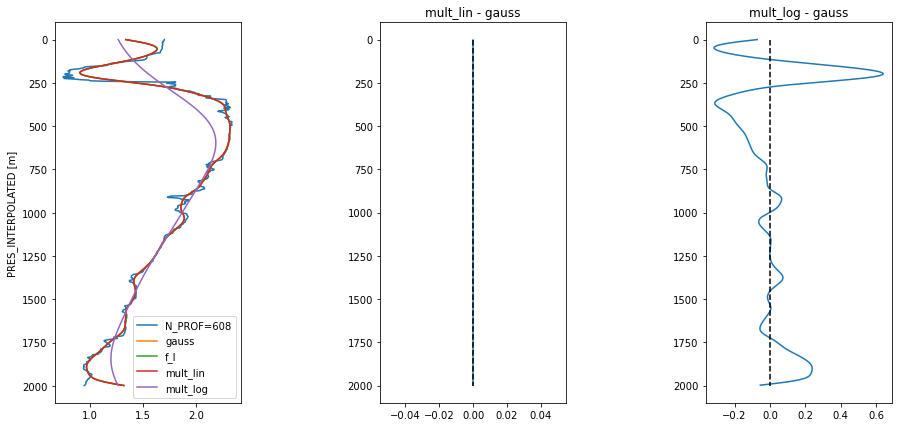

In [108]:
plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
plt.plot(f, x, label='N_PROF={}'.format(f_num))
plt.plot(f_l_gauss, x, label='gauss')
plt.plot(f_l.sel(N_PROF=f_num), x, label='f_l')
plt.plot(mult_lin.sel(N_PROF=f_num).sel(FILT_SCALE=100), x, label='mult_lin')
plt.plot(mult_log.sel(N_PROF=f_num).isel(FILT_SCALE=-1), x, label='mult_log')
plt.gca().invert_yaxis()
plt.ylabel('PRES_INTERPOLATED [m]')
plt.legend()

plt.subplot(1,3,2)
plt.plot(mult_lin.sel(N_PROF=f_num).sel(FILT_SCALE=100)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('mult_lin - gauss')

plt.subplot(1,3,3)
plt.plot(mult_log.sel(N_PROF=f_num).isel(FILT_SCALE=-1)-f_l_gauss, x)
plt.vlines(0,0,2000, linestyles='dashed', color='black')
plt.gca().invert_yaxis()
plt.title('mult_log - gauss')

plt.subplots_adjust(wspace=0.75)

This shows that mult_lin is working quite well, but something is definitely off with mult_log. I'm wondering if it's because I use np.logspace() before calculating the other scales (sigmafilters, nfilters) which are then off in the end. More work needs to be done fixing this!

## MKE/EKE method from Steinberg paper

These eqations are for energy at one spatial scale, where the eddy kinetic energy at scales smaller than the filter scale (EKE) and mean kinetic energy at scales larger than the filter scale (MKE) are:

$$
MKE = <u>^2
$$
$$
EKE = <u^2> - <u>^2
$$

(based on this paper: [Steinberg](https://journals.ametsoc.org/view/journals/phoc/52/8/JPO-D-21-0269.1.xml))

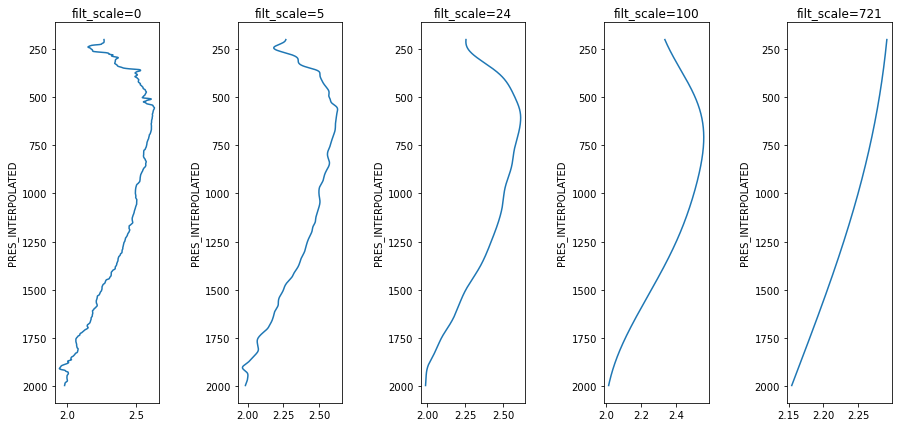

In [12]:
#this is with my_stats functions!

plt.figure(figsize=(15,7))

plt.subplot(1,5,1)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=0).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=0))))

plt.subplot(1,5,2)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=15).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=15))))

plt.subplot(1,5,3)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=25).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=25))))

plt.subplot(1,5,4)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=35).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=35))))

plt.subplot(1,5,5)
aselect_filt.isel(N_PROF=1).isel(FILT_SCALE=-1).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('filt_scale={}'.format(int(aselect_filt.FILT_SCALE.isel(FILT_SCALE=-1))))

plt.subplots_adjust(wspace=0.75)

In [175]:
l=35
aselect_filt_l=aselect_filt.isel(FILT_SCALE=l)

MKE=aselect_filt_l**2

Text(0.5, 1.0, 'Argo Box')

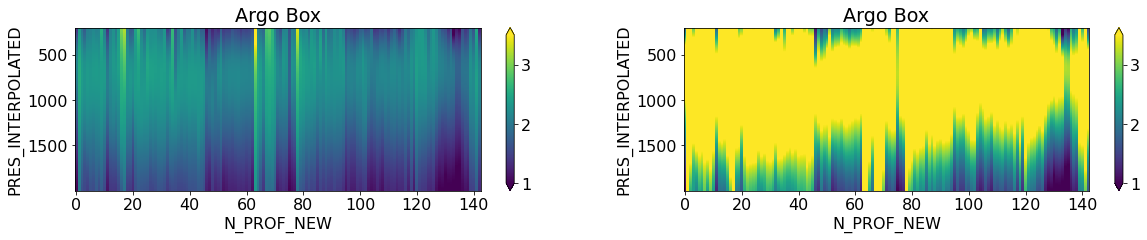

In [190]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
aselect_filt_l.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplot(1,2,2)
MKE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

In [ ]:
#need to square signal, then filter this
#running into problems because get_ds_filt assumes it's reading in full array
####not just the TEMP info
u2 = aselect.TEMP**2
u2_filt = 

#EKE = u2_filt - MKE

In [ ]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
aselect_filt_l.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')

plt.subplot(1,2,2)
EKE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=1,vmax=3.5)
plt.gca().invert_yaxis()
plt.title('Argo Box')